Last updated by: Jonathan Liu, 10/15/2020

In this notebook we will investigate the behavior of onset time distributions for the simple case of a Markov chain with irreversible transitions and identical transition rates. We will discover that a transiently increasing rate results in lower noise in the ensuing onset time than a steady-state rate.

First, consider a Markov chain with $k+1$ states and $k$ irreversible transitions rates, each with rate $\beta$. Labeling the first state with index $0$, the next with $1$, and so on, we have the reaction network:

\begin{equation}
0 \xrightarrow{\beta} 1 \xrightarrow{\beta} ... \xrightarrow{\beta} k
\end{equation}

We will be interested in the mean and variance of the distribution of times $P_k(t)$ to start at state $0$ and reach the final state $k$.

We will first consider the simple case where the transition rate $\beta$ is constant in time. In this case, the distribution $P_k(t)$ is simply given by a Gamma distribution with shape parameter $k$ and rate parameter $\beta$. $P_k(t)$ then has the form

\begin{equation}
P_k(t) = \frac{\beta^k}{\Gamma(k)}t^{k-1}e^{-\beta t}
\end{equation}

where $\Gamma$ is the Gamma function.

The mean $\mu_k$ and variance $\sigma^2_k$ have simple analytical expressions and are given by

\begin{equation}
\mu_k = \frac{k}{\beta} \\
\sigma^2_k = \frac{k}{\beta^2}
\end{equation}

Next, we can examine this system from the perspective of developmental biology. For example, let's consider the system to model the transition of chromatin from an inaccessible, silent state to an accessible, transcriptionally competent state. This could correspond to the time immediately following a nuclear division in the early fruit fly embryo. From a developmental perspective, it's important that $\mu_k$ and $\sigma^2_k$ can be tuned for optimal performance. Namely, given a target mean onset time $\mu$, we would like to minimize the resulting noise $\sigma^2$ in the distribution of onset times around that mean.

For ease of visualization, we will work with the squared CV $CV^2 = \frac{\sigma^2}{\mu^2}$, instead of the variance.

In [1]:
#Import necessary packages
#matplotlib inline
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import scipy.special as sps

In [2]:
#Simulation for calculating onset times

def CalculatetOn_NEqualTransitions(time,dt,w,N_trans,N_cells):
#Calculates the onset time for a model with N irreversible transitions of
#equal magnitude. The transition rate can be time-varying, but is the same
#global rate for each transition. The model assumes N+1 states, beginning
#in the 0th state. Using finite timesteps and a Markov chain formalism, it
#simulates N realizations of the overall time it takes to reach the
#(N+1)th state. This is vectorized so it calculates it for all AP
#positions.

#Last updated by Jonathan Liu, 10/15/2020

# Inputs:
#   time: simulation time vector
#   dt: simulation timestep
#   w: transition probability vector at each timepoint
#   N_trans: number of irreversible transitions
#   N_cells: number of cells to simulate

# Outputs:
#   t_on: time to reach the final state for each cell (length = N_cells)

## Setup variables
    t_on = np.empty(N_cells) #Time to transition to final ON state for each cell
    t_on[:] = np.nan
    state = np.zeros(N_cells) #State vector describing current state of each cell
    finished_states = np.zeros(N_cells) #Vector storing finished statuses of each cell

    ## Run simulation
    #Loop over time
    #q = waitbar(0,'Running simulation...')
    for i in range(len(time)):
        if np.sum(finished_states) == N_cells: #If all cells have turned on, stop the simulation
            #print('Halting simulation since all cells have turned on.')
            break
        #Simulate binomial random variable to see if each cell has transitioned
        #If the input transition rate is a nan, this will manifest as never
        #transitioning.
        p = w[i] * dt #Probability of transition at this timestep
        transitioned = np.random.binomial(1,p,N_cells) #Binary transition decision for each cell

        #Advance the cells that did transition to the next state
        states_to_advance = transitioned == 1
        state[transitioned == 1] = state[transitioned == 1] + 1

        #See if any states have reached the ON state
        t_on[state == N_trans] = time[i]
        finished_states[state == N_trans] = 1
        state[state == N_trans] = np.nan #Move finished states out of consideration

        #waitbar(i/length(time),q,'Running simulation...')
    return t_on

The ensuing code calculates the mean and squared CV for varying values of the step number $k$ and the transition rate $\beta$. The final results can be easily visualized in a 2D parameter space, with the mean $mu_k$ as the x axis and the squared CV $\CV^2_k$ as the y axis. We see that the squared CV is constant with regards to the mean. Of particular interest is the boundary at the bottom of the parameter space. For a given mean and upper limit to $k$ and $\beta$, there is a minimum squared CV below which is unachievable.

Text(0, 0.5, 'CV^2')

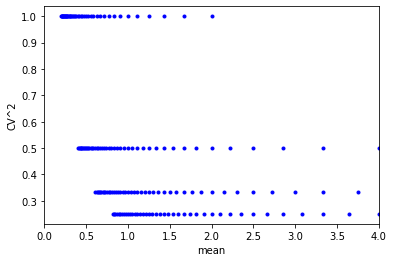

In [8]:
#Plot the mean and variance of the Gamma distribution in 2D parameter space, for a given set of parameters
#Function returning the mean and variance of a Gamma distribution
def MeanVarGamDist(shape,rate):
    return shape/rate, shape/rate**2

#Let's create a grid of shape and rate parameters
n_steps = np.arange(1,5)
rate = np.arange(0.5,5,0.1)
means_const = np.zeros((len(n_steps),len(rate)))
variances_const = np.zeros((len(n_steps),len(rate)))

for i in range(len(n_steps)):
    for j in range(len(rate)):
        means_const[i,j], variances_const[i,j] = MeanVarGamDist(n_steps[i],rate[j])

CV2_const = variances_const / means_const**2
        

    
plt.figure()
plt.plot(means_const,CV2_const, 'b.')
plt.xlim(0,4)
plt.xlabel('mean')
plt.ylabel('CV^2')


Next, we will investigate the changes to this parameter space by using a transient rate $\beta(t)$. This is of biological interest because many developmental processes occur out of steady state. For example, several models of chromatin accessibility hypothesize that the rate of chromatin state transitioning is coupled to the activity of pioneer factors like Zelda. During each rapid cell cycle division event in the early fly embryo, the nuclear membrane breaks down and reforms again, and transcription factors are expelled and re-introduced back into the nucleus. Thus, after each division event, there is a transient period during which the concentration of pioneer factors at a given gene locus is out of steady state.

For now, we will assume a reasonable form for the transition rate. Considering $\beta$ to be a proxy for Zelda concentration, for example, we will write down this transient $\beta(t)$ as the result of a simple diffusive process with form

\begin{equation}
\beta(t) = \beta (1 - e^{-t / \tau} )
\end{equation}

Here, $\beta$ is the asymptotic, saturating value of $\beta(t)$, and $\tau$ is the time constant governing the time-varying nature of the transition rate. For a diffusive process, $\tau$ would be highly dependent on the diffusion constant, for example.

For comparison, the time plots of the constant and transient input are shown below, for $\tau = 3$ and $\beta = 1$.

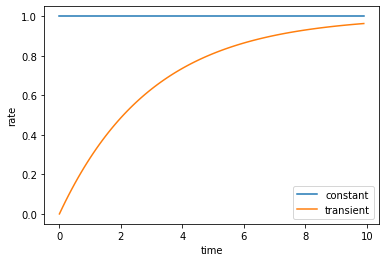

In [4]:
time = np.arange(0,10,0.1)
dt = 0.1
w_base = 1
w_const = w_base * np.ones(time.shape)
N_trans = 2
N_cells = 1000

#Now with transient exponential rate
tau = 3
w_trans = w_base * (1 - np.exp(-time / tau))

#Plot the inputs
plt.figure()
plt.plot(time,w_const,label='constant')
plt.plot(time,w_trans,label='transient')
plt.xlabel('time')
plt.ylabel('rate')
plt.legend()

Because of the time-varying nature of $\beta(t)$, the resulting distribution $P_k(t)$ no longer obeys a simple Gamma distribution, and an analytical solution is difficult (or even impossible). Nevertheless, we can easily simulate the distribution and calculate $\mu_k$ and $\sigma^2_k$ numerically. The results are shown below in red, compared to the steady state case in blue.

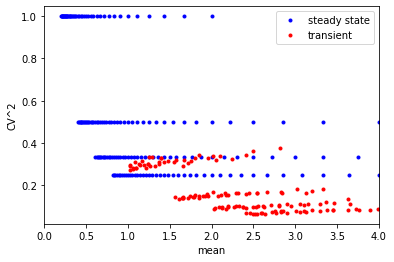

In [10]:
#Now using the transient simulation
time = np.arange(0,10,0.1)
dt = 0.1
N_trans = 2
N_cells = 1000
tau = 3

means_trans = np.zeros((len(n_steps),len(rate)))
CV2_trans = np.zeros((len(n_steps),len(rate)))
for i in range(len(n_steps)):
    for j in range(len(rate)):
        w_trans = rate[j] * (1 - np.exp(-time / tau))
        t_on_trans = CalculatetOn_NEqualTransitions(time,dt,w_trans,n_steps[i],N_cells)
        means_trans[i,j] = np.mean(t_on_trans)
        CV2_trans[i,j] = np.var(t_on_trans)/np.mean(t_on_trans)**2

plt.figure()
plt.plot(means_const,CV2_const, 'b.', label='steady state')
plt.plot(means_trans,CV2_trans, 'r.', label='transient')

plt.xlim(0,4)
plt.xlabel('mean')
plt.ylabel('CV^2')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

We see that the consequence of a slowly increasing transient transition rate is to move the parameter space to the right and down. That is, the transient transition rate serves to increase the mean and decrease the squared CV. This is interesting if we consider, for example, a vertical slice of constant mean. For example, consider the line $\mu = 2$. Here, for a given upper bound on the number of state $k=4$, the steady-state model can only achieve a minimum squared CV of about $0.25$. In contrast, the transient model with a time constant of $\tau = 3$ can achieve a lower minimum squared CV of around $0.15$!

This implies that having a transient transition rate can actually produce a benefit of lowering the noise in onset times for a given mean onset time. While the transient nature of pioneer factor concentrations is an inevitable result of rapid cell divisions, this suggests that the transience can actually be harnessed to decrease overall noise in timing.

To see this more explicitly, let's simulate results for fixed number of steps $k = 3$, for varying values of the transition rate $\beta$. We're also going to change the time constant $\tau$ of the transient input.

Text(0.5, 1.0, 'n = 3 steps, varying rate from 0.5 to 5')

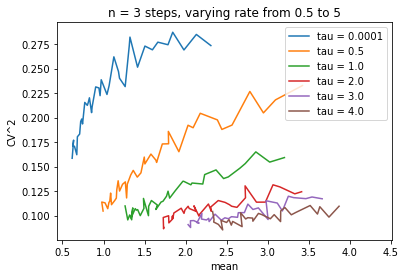

In [11]:
#Model parameters
n_steps = 3
rate = np.arange(0.5,5,0.1)
tau = np.array([0.0001,0.5,1,2,3,4])
means = np.zeros((len(tau),len(rate)))
variances = np.zeros((len(tau),len(rate)))

#Simulation parameters
time = np.arange(0,10,0.1)
dt = 0.1
N_trans = 2
N_cells = 1000


for i in range(len(tau)):
    for j in range(len(rate)):
        w_trans = rate[j] * (1 - np.exp(-time / tau[i]))
        t_on_trans = CalculatetOn_NEqualTransitions(time,dt,w_trans,n_steps,N_cells)
        means[i,j] = np.mean(t_on_trans)
        variances[i,j] = np.var(t_on_trans)
        
CV2 = variances / means**2
        
#Plot results
plt.figure()
for i in range(len(tau)):
    plt.plot(means[i,:],CV2[i,:],label='tau = ' + str(tau[i]))
    
plt.legend()
plt.xlabel('mean')
plt.ylabel('CV^2')
plt.title('n = ' + str(n_steps) + ' steps, varying rate from 0.5 to 5')

The net effect of increasing the time constant, i.e. making the transient input even slower to ramp up, appears to push the curve of squared CV2/mean further to the right and down. However, it appears to asymptote for a slow enough input. Here, the fastest rate used was $\beta = 5$, giving a time scale of $0.2$. It looks like around $\tau = 2$ the curves asymptote, so the rough rule of thumb here is that when the time constant $\tau$ is an order of magnitude slower than the time scale of the transition rates $\beta$, any further slowdown is negligible.

Nevertheless, if we consider a vertical slice of constant mean, we see that transience can decrease the variance by up to a factor of about four!